In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.4/898.4 kB 16.7 MB/s eta 0:00:00


In [6]:
!pip install --upgrade sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 39.5 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.



0: 512x640 7 persons, 391.8ms
Speed: 32.9ms preprocess, 391.8ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 640x160 (no detections), 120.6ms
Speed: 3.2ms preprocess, 120.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 160)


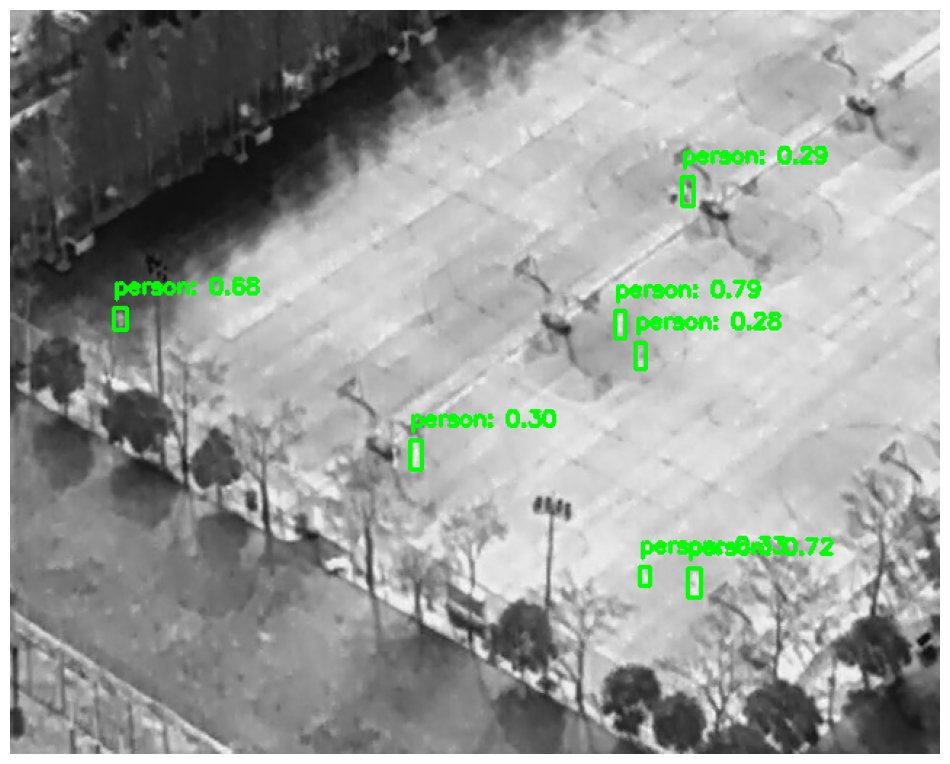

Annotated image saved to: /content/drive/MyDrive/HIT-UAV-Model/annotated_image_1.jpg

0: 512x640 15 cars, 337.6ms
Speed: 2.7ms preprocess, 337.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x160 8 cars, 120.5ms
Speed: 1.6ms preprocess, 120.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)


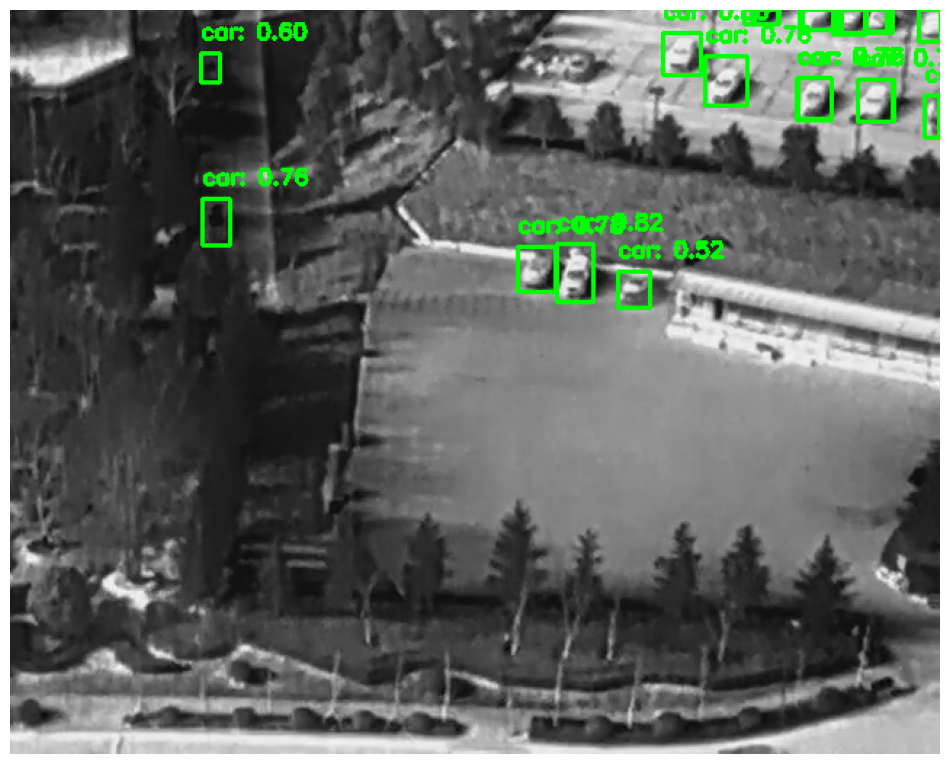

Annotated image saved to: /content/drive/MyDrive/HIT-UAV-Model/annotated_image_2.jpg

0: 512x640 3 persons, 218.3ms
Speed: 3.6ms preprocess, 218.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x160 (no detections), 93.1ms
Speed: 1.6ms preprocess, 93.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 160)


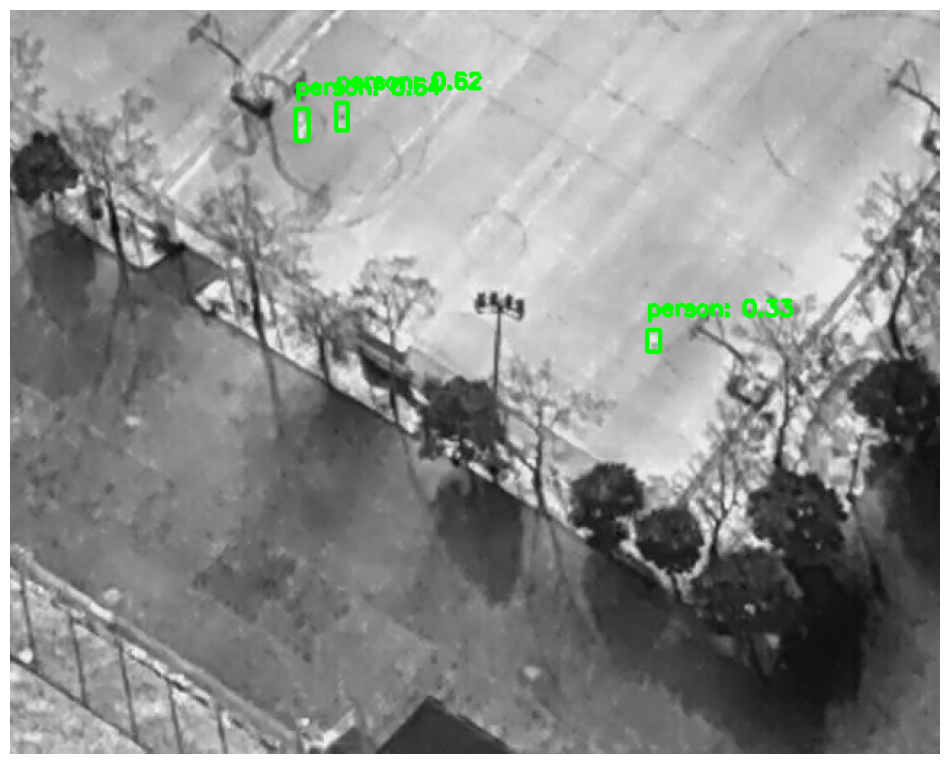

Annotated image saved to: /content/drive/MyDrive/HIT-UAV-Model/annotated_image_3.jpg


In [6]:
import cv2
import numpy as np
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load your YOLO model
model = YOLO("/content/drive/MyDrive/HIT-UAV-Model/best.pt")  # Path to best.pt

# Function to slice an image into smaller patches
def slice_image(image, slice_height, slice_width, overlap):
    h, w, _ = image.shape
    slices = []
    coords = []
    for y in range(0, h, int(slice_height * (1 - overlap))):
        for x in range(0, w, int(slice_width * (1 - overlap))):
            slice_img = image[y:y + slice_height, x:x + slice_width]
            slices.append(slice_img)
            coords.append((x, y))
    return slices, coords

# Function to draw bounding boxes on the original image
def draw_boxes(image, results, coords, slice_size):
    slice_height, slice_width = slice_size
    for i, (result, (x_offset, y_offset)) in enumerate(zip(results, coords)):
        for box in result.boxes:
            if box.xyxy.shape[1] == 4:  # Ensure box.xyxy has 4 coordinates
                x1, y1, x2, y2 = box.xyxy.cpu().numpy().astype(int).flatten()
                conf = box.conf.item()
                label = f"{model.names[int(box.cls)]}: {conf:.2f}"

                # Adjust coordinates to original image space
                x1 += x_offset
                x2 += x_offset
                y1 += y_offset
                y2 += y_offset

                # Draw bounding box
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

# Paths to the test images
image_paths = [
    "/content/drive/MyDrive/hit-uav/images/test/0_100_40_0_03327.jpg",
    "/content/drive/MyDrive/hit-uav/images/test/0_100_30_0_08091.jpg",
    "/content/drive/MyDrive/hit-uav/images/test/0_100_60_0_03386.jpg"
]

# Iterate over each image and process it
for idx, image_path in enumerate(image_paths):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

    # Slice the image
    slice_height, slice_width = 640, 640
    overlap = 0.2
    slices, coords = slice_image(image, slice_height, slice_width, overlap)

    # Perform inference on each slice
    results = [model(slice)[0] for slice in slices]

    # Draw bounding boxes on the original image
    annotated_image = draw_boxes(image.copy(), results, coords, (slice_height, slice_width))

    # Save the annotated image
    output_path = f"/content/drive/MyDrive/HIT-UAV-Model/annotated_image_{idx + 1}.jpg"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

    # Display the result
    plt.figure(figsize=(12, 12))
    plt.imshow(annotated_image)
    plt.axis("off")
    plt.show()

    print(f"Annotated image saved to: {output_path}")